### Importing required libaries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
from tqdm.notebook import tqdm
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from models.old_model import SiameseNetwork

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine
from losses.triplet import TripletLoss

from utils.vis_utils import imshow, show_plot
from utils.other_utils import joinpath, NetworkDataset, TestNetworkDataset, get_dataset
from utils.other_utils import intersection, threshold


In [2]:
# Setup the path where images are located
PATH = r"H:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\data\faces"


# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=1

# no of epoch
EPOCH = 100

# whether it is triplet or contrastive
FLAG = 'triplet'

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])

transformation_for_test = transforms.Compose([transforms.Resize((100,100)),
    transforms.ToTensor(), 
    transforms.RandomApply([
         transforms.RandomRotation([-180,180])], p = 0.2)
])

In [4]:
os.cpu_count() #cpu count

16

For simple visualization purposes let’s look at this example.  
Create a DataLoader of the siamese_dataset and extract the first batch only.  
Combine each combination of images, because our siamese_datasetwill return two images and one label, and print out the labels.

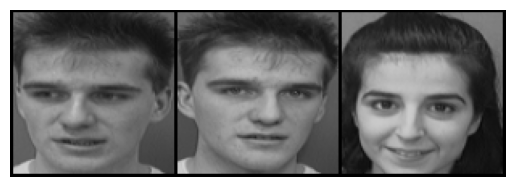

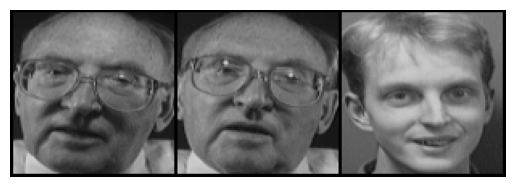

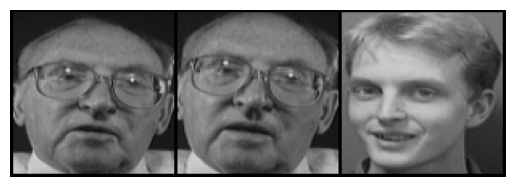

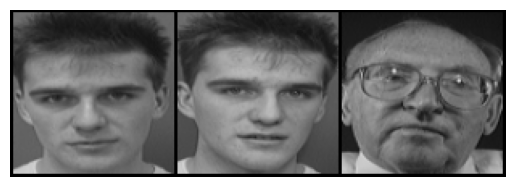

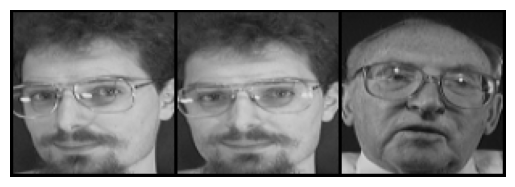

In [5]:
vis_triplet_dataloader,_ =  get_dataset(joinpath(PATH,'train'),transformation,NetworkDataset,FLAG,0,1,True)
for i in range(5):
    example_batch = next(iter(vis_triplet_dataloader))
    images = torch.cat((example_batch[0], example_batch[1], example_batch[2]), dim=0)
    # display the concatenated images
    imshow(torchvision.utils.make_grid(images, nrow=10))
    


In [6]:
train_loader,_ = get_dataset(joinpath(PATH,'train'),transformation,NetworkDataset,FLAG,0,64,True)

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [8]:
# class Network(nn.Module):
#     def __init__(self, emb_dim=128):
#         super(Network, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 32, 5),
#             nn.PReLU(),
#             nn.MaxPool2d(2, stride=2),
#             nn.Dropout(0.3),
#             nn.Conv2d(32, 64, 5),
#             nn.PReLU(),
#             nn.MaxPool2d(2, stride=2),
#             nn.Dropout(0.3)
#         )
        
#         self.fc = nn.Sequential(
#             nn.Linear(64*4*4, 512),
#             nn.PReLU(),
#             nn.Linear(512, emb_dim)
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(-1, 64*4*4)
#         x = self.fc(x)
#         # x = nn.functional.normalize(x)
#         return x

class SiameseNetwork(nn.Module):

    def __init__(self, nchannel):
        super(SiameseNetwork, self).__init__()
        self.nchannel = nchannel

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(self.nchannel, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,128)
        )

    def forward_once(self, x):
        x = self.cnn1(x)
        
        x = x.view(-1, 384)
        x = self.fc1(x)
            # x = nn.functional.normalize(x)
        return x
    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [9]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [10]:
# embedding_dims = 128
model = SiameseNetwork(nchannel=1)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())


In [11]:

model.train()
losses = []
for epoch in tqdm(range(EPOCH), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label,_,_) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model.forward_once(anchor_img)
        positive_out = model.forward_once(positive_img)
        negative_out = model.forward_once(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    losses.append(np.mean(running_loss))
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, EPOCH, np.mean(running_loss)))

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1/100 - Loss: 0.6207


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2/100 - Loss: 0.3933


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3/100 - Loss: 0.2650


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4/100 - Loss: 0.2122


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5/100 - Loss: 0.1615


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6/100 - Loss: 0.1649


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7/100 - Loss: 0.1102


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8/100 - Loss: 0.1526


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9/100 - Loss: 0.0693


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10/100 - Loss: 0.1111


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11/100 - Loss: 0.0805


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12/100 - Loss: 0.1009


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13/100 - Loss: 0.0907


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14/100 - Loss: 0.0823


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15/100 - Loss: 0.0890


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16/100 - Loss: 0.0753


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17/100 - Loss: 0.0591


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18/100 - Loss: 0.0313


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19/100 - Loss: 0.0674


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 20/100 - Loss: 0.0791


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 21/100 - Loss: 0.0778


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 22/100 - Loss: 0.1113


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 23/100 - Loss: 0.0687


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 24/100 - Loss: 0.0866


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 25/100 - Loss: 0.0580


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 26/100 - Loss: 0.0438


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 27/100 - Loss: 0.0485


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 28/100 - Loss: 0.0784


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 29/100 - Loss: 0.1286


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 30/100 - Loss: 0.0710


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 31/100 - Loss: 0.1019


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 32/100 - Loss: 0.0712


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 33/100 - Loss: 0.0231


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 34/100 - Loss: 0.0354


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 35/100 - Loss: 0.0639


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 36/100 - Loss: 0.0438


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 37/100 - Loss: 0.0531


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 38/100 - Loss: 0.0258


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 39/100 - Loss: 0.0289


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 40/100 - Loss: 0.0680


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 41/100 - Loss: 0.0444


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 42/100 - Loss: 0.1028


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 43/100 - Loss: 0.0515


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 44/100 - Loss: 0.0411


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 45/100 - Loss: 0.0328


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 46/100 - Loss: 0.0431


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 47/100 - Loss: 0.0519


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 48/100 - Loss: 0.0374


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 49/100 - Loss: 0.0492


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 50/100 - Loss: 0.0312


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 51/100 - Loss: 0.0321


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 52/100 - Loss: 0.0375


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 53/100 - Loss: 0.0520


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 54/100 - Loss: 0.0304


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 55/100 - Loss: 0.0359


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 56/100 - Loss: 0.0430


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 57/100 - Loss: 0.0239


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 58/100 - Loss: 0.0317


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 59/100 - Loss: 0.0352


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 60/100 - Loss: 0.0666


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 61/100 - Loss: 0.0343


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 62/100 - Loss: 0.0511


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 63/100 - Loss: 0.0517


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 64/100 - Loss: 0.0628


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 65/100 - Loss: 0.0375


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 66/100 - Loss: 0.0369


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 67/100 - Loss: 0.0208


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 68/100 - Loss: 0.0365


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 69/100 - Loss: 0.0239


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 70/100 - Loss: 0.0306


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 71/100 - Loss: 0.0194


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 72/100 - Loss: 0.0137


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 73/100 - Loss: 0.0248


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 74/100 - Loss: 0.0437


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 75/100 - Loss: 0.0260


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 76/100 - Loss: 0.0264


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 77/100 - Loss: 0.0236


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 78/100 - Loss: 0.0126


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 79/100 - Loss: 0.0416


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 80/100 - Loss: 0.0194


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 81/100 - Loss: 0.0632


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 82/100 - Loss: 0.0342


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 83/100 - Loss: 0.0313


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 84/100 - Loss: 0.0310


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 85/100 - Loss: 0.0027


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 86/100 - Loss: 0.0124


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 87/100 - Loss: 0.0299


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 88/100 - Loss: 0.0124


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 89/100 - Loss: 0.0140


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 90/100 - Loss: 0.0308


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 91/100 - Loss: 0.0083


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 92/100 - Loss: 0.0408


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 93/100 - Loss: 0.0271


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 94/100 - Loss: 0.0229


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 95/100 - Loss: 0.0135


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 96/100 - Loss: 0.0694


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 97/100 - Loss: 0.0344


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 98/100 - Loss: 0.0279


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 99/100 - Loss: 0.0381


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 100/100 - Loss: 0.0359


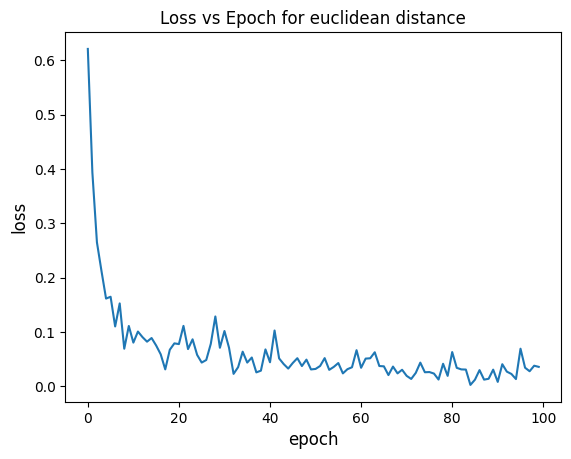

In [12]:

# Plotting the loss vs epoch
plt.figure()
plt.title('Loss vs Epoch for euclidean distance')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
counter = list(range(EPOCH))
show_plot(counter, losses)

In [13]:
#### here we create dataiter for test

# Locate the test dataset and load it into the SiameseNetworkDataset_for_test
if testing:
    test_dataloader,_ = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)

    # Grab one image that we are going to test
    dataiter = iter(test_dataloader)
    x0,_ = next(dataiter)


    #### here we create dataiter for train.

    # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
    train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

    dataiter_train = iter(train_dataloader)

    score = []

    for i in range(len(siamese_dataset_train)):
        # Iterate over all images and test them with the first image (x0)
        x1,_ = next(dataiter_train)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)
        
        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        score.append(round(euclidean_distance.item(),2))
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        # cosine_distance = torch.cosine_similarity(output1, output2)
        # score.append(round(cosine_distance.item(),2))
        # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

Now we test all the test images with all the train images and all combination are unique.

In [16]:
#### here we create dataiter for test

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, TestNetworkDataset,FLAG, 0, 1, True)

#### here we create dataiter for train

train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, TestNetworkDataset,FLAG, 0, 1, False)


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]
count_label0 = []
count_label1 = []


dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    
    x0,label0 = next(dataiter)
    count_label0.append(label0)
    

# Grab one image that we are going to test
    dataiter_train = iter(train_dataloader)

    for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label1 = next(dataiter_train)
        count_label1.append(label1)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = model(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())


        # cosine_distance = torch.cosine_similarity(output1, output2)
        # predict.append(cosine_distance.item())
        # if label0==label1:
        #     same_disssimilarity.append(cosine_distance.item())
        # else:
        #     different_disssimilarity.append(cosine_distance.item())

In [17]:
# checking if there are any intersection in same and different images
print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

Number of total interesection:  5492


C:\Users\AkshatGarg\AppData\Local\Temp\ipykernel_5516\3183135136.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
C:\Users\AkshatGarg\AppData\Local\Temp\ipykernel_5516\3183135136.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwas

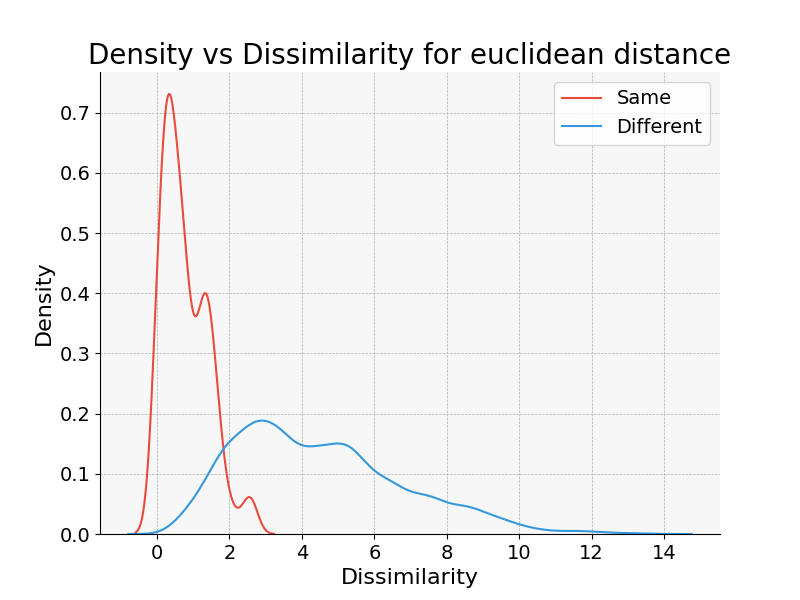

In [18]:
# Plotting the distribution for same vs dissimilar images density plot

%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt

# Set custom color palette
colors = ["#E74C3C", "#3498DB"]

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Set background color
ax.set_facecolor("#F7F7F7")

# Plot the distributions and set custom colors
sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
sns.distplot(different_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Different", color=colors[1])

# Add legend and title
plt.legend(fontsize=14)
plt.title('Density vs Dissimilarity for euclidean distance', fontsize=20)

# Add gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Set axis labels and tick sizes
plt.xlabel("Dissimilarity", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()

In [21]:
# checking for mean/average score
from statistics import mean
print("Mean of same images: ",mean(same_disssimilarity))
print("Mean of different images: ",mean(different_disssimilarity))

Mean of same images:  0.9203537123157245
Mean of different images:  4.987222000839504


In [22]:
# Prinitng total number of combinations that we tested on
print("Total number of combinations of same images: ", len(same_disssimilarity))
print("Total number of combinations of different images: ", len(different_disssimilarity))
print("Total number of combinations: ", len(same_disssimilarity) + len(different_disssimilarity))

Total number of combinations of same images:  300
Total number of combinations of different images:  21900
Total number of combinations:  22200


In [23]:
# Checking for number of missclassified images
final_list, same_misclassified, different_misclassified = threshold(same_disssimilarity,different_disssimilarity,0.25)

print("Total number of missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(final_list))
print("Total number of same class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(same_misclassified))
print("Total number of different class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(different_misclassified))

Total number of missclassified for threshold score  0.3  missclassified images:  270
Total number of same class missclassified for threshold score  0.3  missclassified images:  270
Total number of different class missclassified for threshold score  0.3  missclassified images:  0


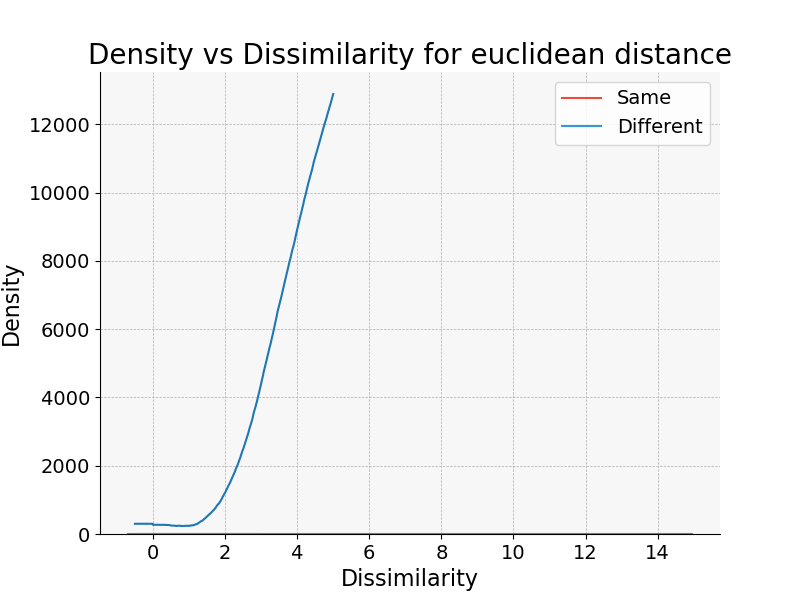

In [24]:
import numpy as np
final_list_1 = {}
for i in np.linspace(-0.5,5,550):
    x,_,_ = threshold(same_disssimilarity,different_disssimilarity,i)
    final_list_1[i] = len(x)

plt.plot(final_list_1.keys(),final_list_1.values())

plt.show()